In [737]:
"""!pip3 install tqdm
!pip3 install ipywidgets 
!pip3 install ipython"""

'!pip3 install tqdm\n!pip3 install ipywidgets \n!pip3 install ipython'

In [901]:
# General
import json
import warnings
import time
import os
import copy
import pickle
import random
from datetime import datetime
from datetime import timedelta
import dateutil.parser

# Data Collection and Processing
from pandas_datareader import DataReader
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook, tnrange
from yahoo_earnings_calendar import YahooEarningsCalendar

# Statistics and Modelling
import statsmodels.api as sm
from scipy.stats import kurtosis
from pmdarima import auto_arima
#import pmdarima as pm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Keras
import tensorflow as tf
import keras
from keras.models import Sequential, load_model, save_model
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout, Flatten

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data as data
from torch.nn.utils import clip_grad_norm_, clip_grad_value_
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.optimizer import Optimizer


## Technical indicators 
import talib

from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_stocktrading import StockTradingEnv
#from finrl.model.models_ext import DRLEnsembleAgent
from finrl.trade.backtest import backtest_stats, backtest_plot, get_baseline


## Hypothesis 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Config
%matplotlib inline
%config InlineBackend.figure_format='retina'
warnings.filterwarnings("ignore")

## 1. Download - Stock - 20 years - Daily : Open, Close, High , Low , Volume

In [902]:
"""data_start = "1994-01-01"
data_end = "2021-07-01"
df =yf.download("MSFT", data_start, data_end)
df_ = df.copy()
df_.head(3)
"""
TICKER = "MSFT"
ticker = yf.Ticker("MSFT")
df = ticker.history(period="max")
df.to_csv(f'{TICKER}.csv')
df = df.reset_index()

df = pd.read_csv(f'{TICKER}.csv')
df['Date'] = pd.to_datetime(df['Date'])

In [903]:
# # setting the dates
start_date = df.Date.iloc[0]
end_date = df.Date.iloc[-1]

# # downloading the earnings calendar
yec = YahooEarningsCalendar()
earnings_list = yec.get_earnings_of(TICKER)
earnings_df = pd.DataFrame(earnings_list)

# # extracting the date from the string and filtering for the period of interest
earnings_df['report_date'] = earnings_df['startdatetime'] \
     .apply(lambda x: dateutil.parser.isoparse(x).date())

earnings_df = earnings_df.loc[earnings_df['report_date'].between(start_date, end_date)] \
                          .sort_values('report_date')

earnings_df.to_csv(f'earnings_{TICKER}.csv')

earnings_df = pd.read_csv(f'earnings_{TICKER}.csv')

# Convert Date column to datetime
earnings_df['Date'] = pd.to_datetime(earnings_df['report_date'])

edf = earnings_df[['Date']]
edf['earnings'] = 1

df = pd.merge(df, edf, on='Date', how='left')
df = df.fillna(0)

print(f'There are {df.earnings.sum()} earning dates released')

There are 96.0 earning dates released


In [904]:
df = df.set_index('Date')

In [905]:
## Percentage Return of Close price 
df["Return"] = np.log(df["Close"]) - np.log(df["Close"].shift(1))
#df_["Pct_change"] = df_["Close"].pct_change().dropna(axis=0)
df = df.dropna(axis =0)
df = df_.reset_index()
df

,Date,Dividends,Stock Splits,earnings,upper_band,sma_21Lag_1,sma_21Lag_2,sma_21Lag_3,MACDLag_1,MACDLag_2,...,lower_bandLag_2,lower_bandLag_3,upper_bandLag_1,upper_bandLag_2,upper_bandLag_3,ReturnLag_1,ReturnLag_2,ReturnLag_3,ReturnLag_4,ReturnLag_5
0,1986-04-18,0.0,0.0,0.0,0.066437,0.063887,0.063023,0.062158,0.000916,0.000708,...,0.057030,0.057438,0.066075,0.065197,0.064514,0.008298,0.033908,0.000000,0.008658,0.017544
1,1986-04-21,0.0,0.0,0.0,0.066699,0.064280,0.063887,0.063023,0.000913,0.000916,...,0.056591,0.057030,0.066437,0.066075,0.065197,-0.033614,0.008298,0.033908,0.000000,0.008658
2,1986-04-22,0.0,0.0,0.0,0.066532,0.064595,0.064280,0.063887,0.000901,0.000913,...,0.056615,0.056591,0.066699,0.066437,0.066075,0.000000,-0.033614,0.008298,0.033908,0.000000
3,1986-04-23,0.0,0.0,0.0,0.066454,0.064595,0.064595,0.064280,0.000802,0.000901,...,0.056903,0.056615,0.066532,0.066699,0.066437,-0.017251,0.000000,-0.033614,0.008298,0.033908
4,1986-04-24,0.0,0.0,0.0,0.067988,0.064555,0.064595,0.064595,0.000736,0.000802,...,0.057675,0.056903,0.066454,0.066532,0.066699,0.004338,-0.017251,0.000000,-0.033614,0.008298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8870,2021-06-28,0.0,0.0,0.0,271.424971,263.635712,262.544285,261.354283,4.276924,4.242116,...,243.189517,243.304733,269.910722,268.945482,267.310266,-0.006282,0.005339,-0.000904,0.010906,0.012259
8871,2021-06-29,0.0,0.0,0.0,272.989216,264.752856,263.635712,262.544285,4.550613,4.276924,...,243.795276,243.189517,271.424971,269.910722,268.945482,0.013865,-0.006282,0.005339,-0.000904,0.010906
8872,2021-06-30,0.0,0.0,0.0,273.992228,266.462856,264.752856,263.635712,4.926971,4.550613,...,244.185028,243.795276,272.989216,271.424971,269.910722,0.009924,0.013865,-0.006282,0.005339,-0.000904
8873,2021-07-01,0.0,0.0,0.0,274.398683,267.644283,266.462856,264.752856,5.125805,4.926971,...,245.020783,244.185028,273.992228,272.989216,271.424971,-0.001844,0.009924,0.013865,-0.006282,0.005339


## 2. Function to generate list of Technical Indicators 

In [869]:
def get_technical_indicators(dataset):

    # Create 7 and 21 days Moving Average
    dataset["sma_21"] = talib.SMA(dataset["Close"],7)
    #dataset["sma_7"] = talib.SMA(df_["Close"],7)
    #dataset['ma7'] = dataset['Close'].rolling(window = 7).mean()
    #dataset['ma21'] = dataset['Close'].rolling(window = 21).mean()
    
    #Create MACD
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])
    
    #Create Bollinger Bands
    dataset['20sd'] = dataset['Close'].rolling(window = 20).std()
    dataset['upper_band'] = (dataset['Close'].rolling(window = 20).mean()) + (dataset['20sd']*2)
    dataset['lower_band'] = (dataset['Close'].rolling(window = 20).mean()) - (dataset['20sd']*2)
    
    
    #Exponential moving average
    #dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
    
    # Momentum
    dataset['momentum'] = talib.MOM(dataset['Close'], timeperiod=10)
      
    return dataset

df = get_technical_indicators(df).dropna()
df.head(5)


,Open,High,Low,Close,Volume,Dividends,Stock Splits,earnings,Return,sma_21,26ema,12ema,MACD,20sd,upper_band,lower_band,momentum
Date,,,,,,,,,,,,,,,,,
1986-04-11,0.062708,0.064359,0.062708,0.063258,17222400,0.0,0.0,0.0,0.017544,0.061373,0.061046,0.061268,0.000222,0.001876,0.064782,0.057279,0.002200
1986-04-14,0.063259,0.064359,0.063259,0.063809,12153600,0.0,0.0,0.0,0.008658,0.061766,0.061301,0.061671,0.000369,0.001876,0.064782,0.057279,0.003300
1986-04-15,0.063809,0.063809,0.061608,0.063809,9302400,0.0,0.0,0.0,0.000000,0.062158,0.061529,0.062008,0.000479,0.001769,0.064514,0.057438,0.003850
1986-04-16,0.063809,0.066559,0.063258,0.066009,31910400,0.0,0.0,0.0,0.033908,0.063023,0.061929,0.062637,0.000708,0.002042,0.065197,0.057030,0.005501
1986-04-17,0.066009,0.066559,0.066009,0.066559,22003200,0.0,0.0,0.0,0.008298,0.063887,0.062336,0.063252,0.000916,0.002371,0.066075,0.056591,0.005501


In [870]:
def test_stationarity(df, ts):
    # Determing rolling statistics

    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(df[ts], autolag='AIC')  # add kpss
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '# Lags Used', 'Number of Observations Used'])

    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    

    if (dfoutput[0] < 0.05) :
        print("\nTime Series Stationary as P value ( {} ) < 0.05".format(round(dftest[1],5)))
    else:
        print("\nTime Series Stationary as P value ( {} ) > 0.05".format(round(dftest[1],5)))

    return dfoutput


#df_["Pct_Change_30"] = pd.DataFrame(df_["Close"].pct_change(periods=30).dropna(axis=0))
df = df.dropna(axis=0)
test_Stationary =  test_stationarity(df,"Return")

Results of Dickey-Fuller Test:

Time Series Stationary as P value ( 0.0 ) < 0.05


In [871]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,earnings,Return,sma_21,26ema,12ema,MACD,20sd,upper_band,lower_band,momentum
Date,,,,,,,,,,,,,,,,,
1986-04-11,0.062708,0.064359,0.062708,0.063258,17222400,0.0,0.0,0.0,0.017544,0.061373,0.061046,0.061268,0.000222,0.001876,0.064782,0.057279,0.002200
1986-04-14,0.063259,0.064359,0.063259,0.063809,12153600,0.0,0.0,0.0,0.008658,0.061766,0.061301,0.061671,0.000369,0.001876,0.064782,0.057279,0.003300
1986-04-15,0.063809,0.063809,0.061608,0.063809,9302400,0.0,0.0,0.0,0.000000,0.062158,0.061529,0.062008,0.000479,0.001769,0.064514,0.057438,0.003850
1986-04-16,0.063809,0.066559,0.063258,0.066009,31910400,0.0,0.0,0.0,0.033908,0.063023,0.061929,0.062637,0.000708,0.002042,0.065197,0.057030,0.005501
1986-04-17,0.066009,0.066559,0.066009,0.066559,22003200,0.0,0.0,0.0,0.008298,0.063887,0.062336,0.063252,0.000916,0.002371,0.066075,0.056591,0.005501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-28,266.190002,268.899994,265.910004,268.720001,19590000,0.0,0.0,0.0,0.013865,264.752856,257.905889,262.456502,4.550613,6.809986,271.424971,244.185028,8.829987
2021-06-29,268.869995,271.649994,267.980011,271.399994,19937800,0.0,0.0,0.0,0.009924,266.462856,258.905453,263.832424,4.926971,6.992108,272.989216,245.020783,13.040009
2021-06-30,270.690002,271.359985,269.600006,270.899994,21656500,0.0,0.0,0.0,-0.001844,267.644283,259.793937,264.919742,5.125805,6.903614,273.992228,246.377771,13.519989


# 4. Lagging the Data

In [872]:
# Since we're going to forecast the one day ahead Nifty stock returns, the minimum lag considered by me is 1
minLagNum = 1

#lagging the vars :here i'm iginoring the ACF and PACF lag structure and deciding the maximum number of lags heuristically
maxLagNum = 3 #here I have chosen the maxLagNum arbitrarily. A better strategy is to look at the acf plot
dataForMl = df
col = ['sma_21','MACD', '20sd', 'momentum' ,'lower_band','upper_band' ]

for column in col:
    for lag in range(minLagNum,maxLagNum+1):
        dataForMl[f'{column}Lag_{lag}'] = dataForMl[f'{column}'].shift(lag)

for column in ['Return']:
    for lag in range(1,5+1):
        dataForMl[f'{column}Lag_{lag}'] = dataForMl[f'{column}'].shift(lag)
        

df = dataForMl.dropna()

In [873]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,earnings,Return,sma_21,...,lower_bandLag_2,lower_bandLag_3,upper_bandLag_1,upper_bandLag_2,upper_bandLag_3,ReturnLag_1,ReturnLag_2,ReturnLag_3,ReturnLag_4,ReturnLag_5
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-18,0.066559,0.066559,0.063809,0.064359,21628800,0.0,0.0,0.0,-0.033614,0.064280,...,0.057030,0.057438,0.066075,0.065197,0.064514,0.008298,0.033908,0.000000,0.008658,0.017544
1986-04-21,0.064359,0.064909,0.062708,0.064359,22924800,0.0,0.0,0.0,0.000000,0.064595,...,0.056591,0.057030,0.066437,0.066075,0.065197,-0.033614,0.008298,0.033908,0.000000,0.008658
1986-04-22,0.064359,0.064359,0.063258,0.063258,15552000,0.0,0.0,0.0,-0.017251,0.064595,...,0.056615,0.056591,0.066699,0.066437,0.066075,0.000000,-0.033614,0.008298,0.033908,0.000000
1986-04-23,0.063258,0.063809,0.062708,0.063533,15609600,0.0,0.0,0.0,0.004338,0.064555,...,0.056903,0.056615,0.066532,0.066699,0.066437,-0.017251,0.000000,-0.033614,0.008298,0.033908
1986-04-24,0.063533,0.070960,0.063258,0.069860,62352000,0.0,0.0,0.0,0.094920,0.065420,...,0.057675,0.056903,0.066454,0.066532,0.066699,0.004338,-0.017251,0.000000,-0.033614,0.008298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-28,266.190002,268.899994,265.910004,268.720001,19590000,0.0,0.0,0.0,0.013865,264.752856,...,243.189517,243.304733,269.910722,268.945482,267.310266,-0.006282,0.005339,-0.000904,0.010906,0.012259
2021-06-29,268.869995,271.649994,267.980011,271.399994,19937800,0.0,0.0,0.0,0.009924,266.462856,...,243.795276,243.189517,271.424971,269.910722,268.945482,0.013865,-0.006282,0.005339,-0.000904,0.010906
2021-06-30,270.690002,271.359985,269.600006,270.899994,21656500,0.0,0.0,0.0,-0.001844,267.644283,...,244.185028,243.795276,272.989216,271.424971,269.910722,0.009924,0.013865,-0.006282,0.005339,-0.000904


the time series reaches stationarity with two orders of differencing


<Figure size 1080x840 with 0 Axes>

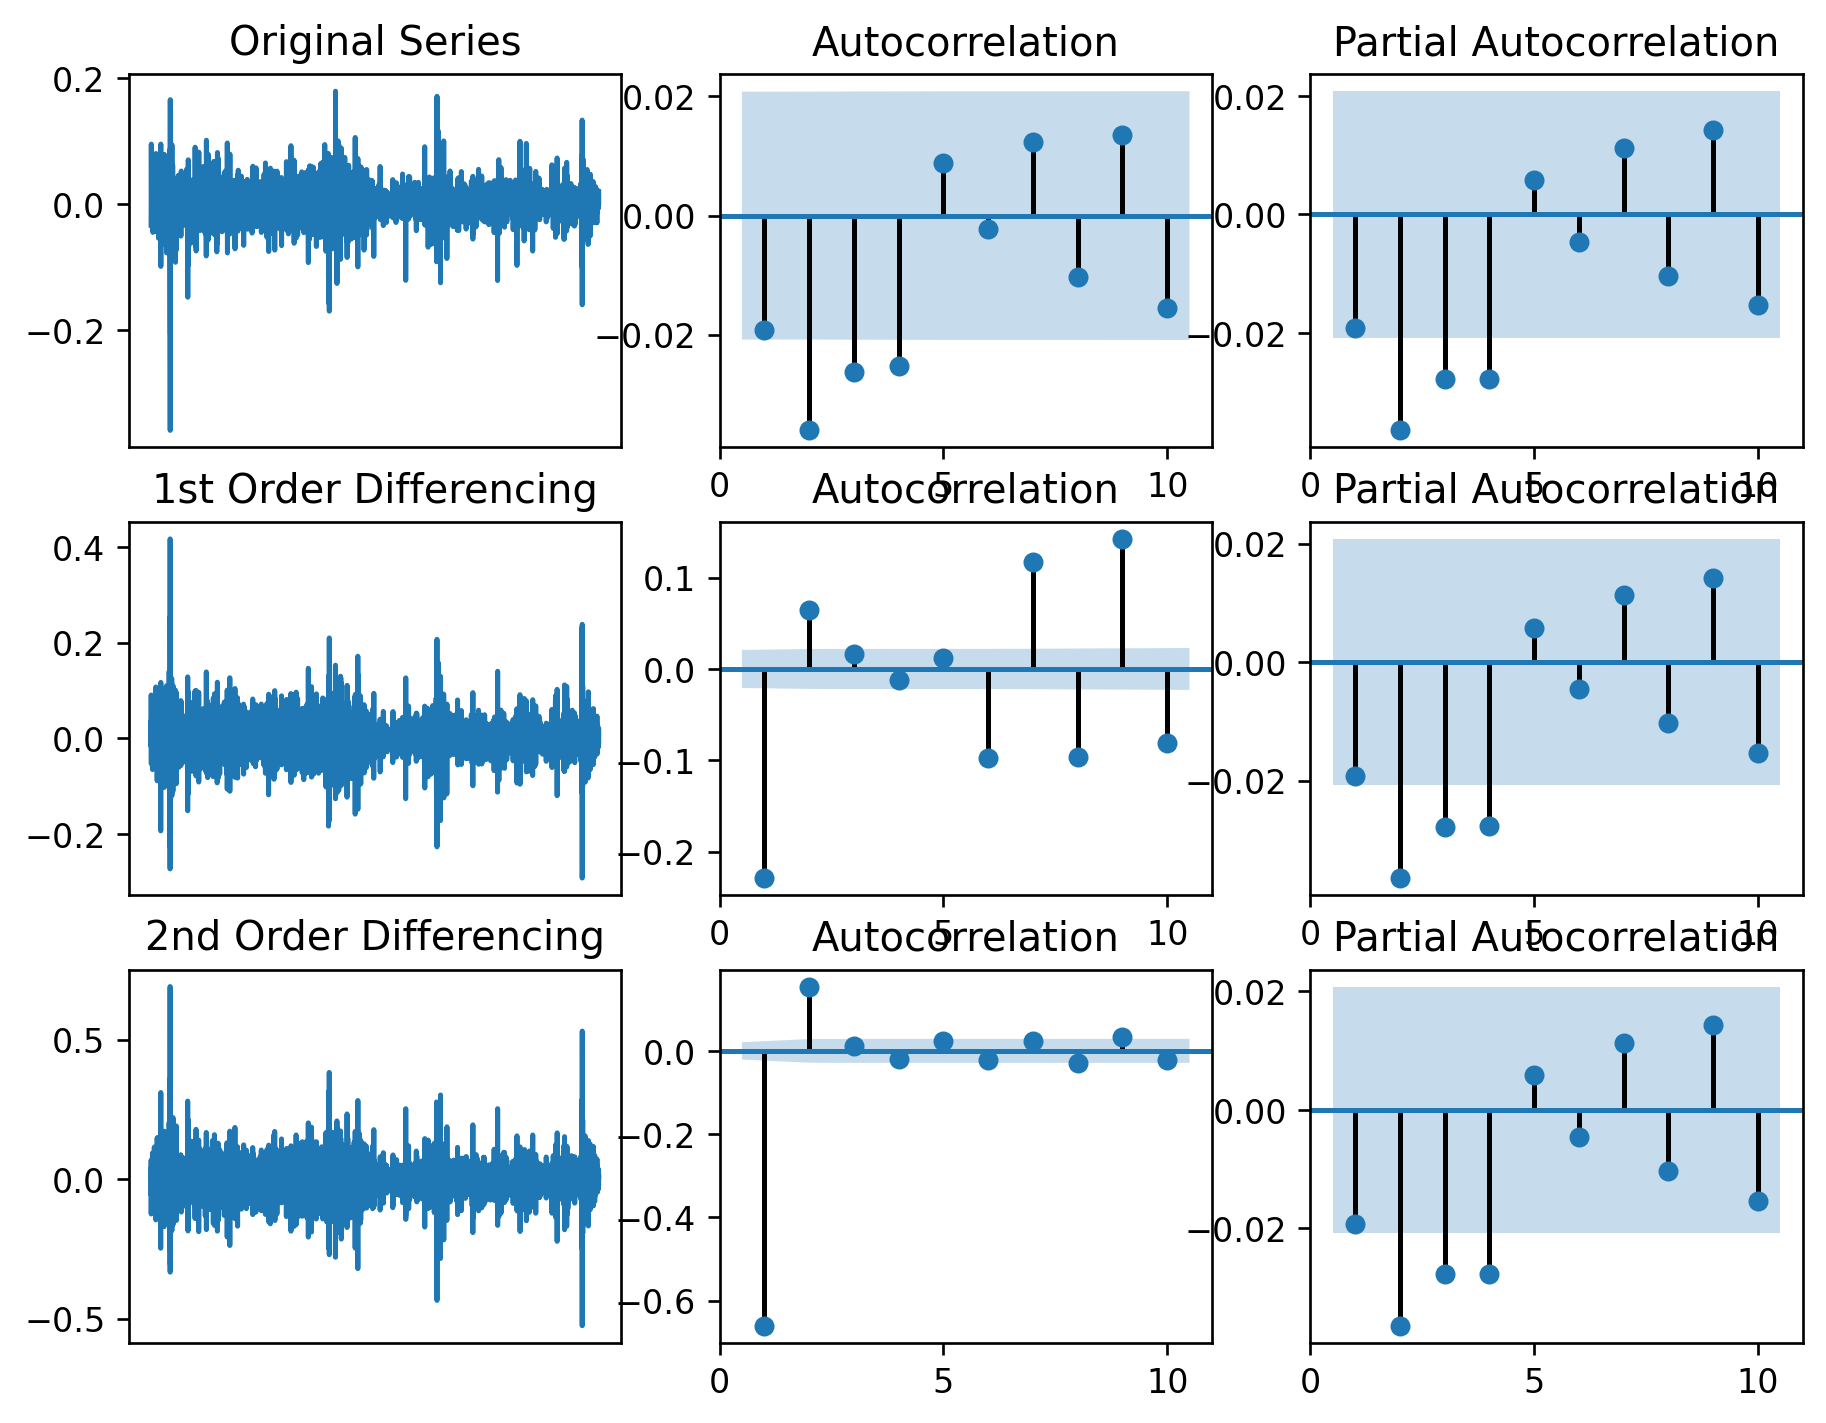

In [874]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
plt.subplots_adjust(top = 1, bottom=0.1, hspace=1.5, wspace=0.4)
# Import data

print ( "the time series reaches stationarity with two orders of differencing")

# Original Series
fig, axes = plt.subplots(3, 3, sharex=False)
axes[0, 0].axes.xaxis.set_visible(False)
axes[0, 0].plot(df["Return"])
axes[0, 0].set_title('Original Series')
plot_acf(df["Return"], ax=axes[0, 1],lags=10, zero=False)
plot_pacf(df["Return"], ax=axes[0, 2],lags=10, zero=False)

# 1st Differencing
axes[1, 0].axes.xaxis.set_visible(False)
axes[1, 0].plot(df["Return"].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.Close.diff().dropna(), ax=axes[1, 1],lags=10, zero=False)
plot_pacf(df["Return"], ax=axes[1, 2],lags=10, zero=False)

# 2nd Differencing
axes[2, 0].axes.xaxis.set_visible(False)
axes[2, 0].plot(df.Return.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.Return.diff().dropna().diff().dropna(), ax=axes[2, 1],lags=10, zero=False)
plot_pacf(df["Return"], ax=axes[2, 2],lags=10, zero=False)
plt.show()

# 5. Breaking data into train and test along time dim

In [875]:
# 5. Breaking the data into train and test along time dim
test_percent = 0.10
no_test_obs =  int(np.round(test_percent*len(df)))
training = df[:-no_test_obs]
testing = df[-no_test_obs:]

#breaking the testing data into validation and out of sample data
validation_percent = 0.70
no_validation_obs = int(np.round(validation_percent*len(testing)))
validation = testing[:-no_validation_obs]
outOfSample = testing[-no_validation_obs:]


# 6. Rescaling Normalized Data

In [876]:
df_ = df.drop(columns = {'Open','Return','lower_band','momentum', 'High', 'Low', 'Close', 'Volume','sma_21','26ema','12ema','MACD','20sd',})

In [877]:
df_

,Dividends,Stock Splits,earnings,upper_band,sma_21Lag_1,sma_21Lag_2,sma_21Lag_3,MACDLag_1,MACDLag_2,MACDLag_3,...,lower_bandLag_2,lower_bandLag_3,upper_bandLag_1,upper_bandLag_2,upper_bandLag_3,ReturnLag_1,ReturnLag_2,ReturnLag_3,ReturnLag_4,ReturnLag_5
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-18,0.0,0.0,0.0,0.066437,0.063887,0.063023,0.062158,0.000916,0.000708,0.000479,...,0.057030,0.057438,0.066075,0.065197,0.064514,0.008298,0.033908,0.000000,0.008658,0.017544
1986-04-21,0.0,0.0,0.0,0.066699,0.064280,0.063887,0.063023,0.000913,0.000916,0.000708,...,0.056591,0.057030,0.066437,0.066075,0.065197,-0.033614,0.008298,0.033908,0.000000,0.008658
1986-04-22,0.0,0.0,0.0,0.066532,0.064595,0.064280,0.063887,0.000901,0.000913,0.000916,...,0.056615,0.056591,0.066699,0.066437,0.066075,0.000000,-0.033614,0.008298,0.033908,0.000000
1986-04-23,0.0,0.0,0.0,0.066454,0.064595,0.064595,0.064280,0.000802,0.000901,0.000913,...,0.056903,0.056615,0.066532,0.066699,0.066437,-0.017251,0.000000,-0.033614,0.008298,0.033908
1986-04-24,0.0,0.0,0.0,0.067988,0.064555,0.064595,0.064595,0.000736,0.000802,0.000901,...,0.057675,0.056903,0.066454,0.066532,0.066699,0.004338,-0.017251,0.000000,-0.033614,0.008298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-28,0.0,0.0,0.0,271.424971,263.635712,262.544285,261.354283,4.276924,4.242116,3.965947,...,243.189517,243.304733,269.910722,268.945482,267.310266,-0.006282,0.005339,-0.000904,0.010906,0.012259
2021-06-29,0.0,0.0,0.0,272.989216,264.752856,263.635712,262.544285,4.550613,4.276924,4.242116,...,243.795276,243.189517,271.424971,269.910722,268.945482,0.013865,-0.006282,0.005339,-0.000904,0.010906
2021-06-30,0.0,0.0,0.0,273.992228,266.462856,264.752856,263.635712,4.926971,4.550613,4.276924,...,244.185028,243.795276,272.989216,271.424971,269.910722,0.009924,0.013865,-0.006282,0.005339,-0.000904


In [878]:
columns_list  = list(df_.columns)
columns_list.append('Return')
df = df[columns_list]
df.columns

Index(['Dividends', 'Stock Splits', 'earnings', 'upper_band', 'sma_21Lag_1',
       'sma_21Lag_2', 'sma_21Lag_3', 'MACDLag_1', 'MACDLag_2', 'MACDLag_3',
       '20sdLag_1', '20sdLag_2', '20sdLag_3', 'momentumLag_1', 'momentumLag_2',
       'momentumLag_3', 'lower_bandLag_1', 'lower_bandLag_2',
       'lower_bandLag_3', 'upper_bandLag_1', 'upper_bandLag_2',
       'upper_bandLag_3', 'ReturnLag_1', 'ReturnLag_2', 'ReturnLag_3',
       'ReturnLag_4', 'ReturnLag_5', 'Return'],
      dtype='object')

In [879]:
test_percent = 0.10
no_test_obs =  int(np.round(test_percent*len(df)))
training = df[:-no_test_obs]
testing = df[-no_test_obs:]

#breaking the testing data into validation and out of sample data
validation_percent = 0.70
no_validation_obs = int(np.round(validation_percent*len(testing)))
validation = testing[:-no_validation_obs]
outOfSample = testing[-no_validation_obs:]

In [881]:
from sklearn.preprocessing import MinMaxScaler

exogs = list(df.columns)[:-1]
print (exogs)

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
trainMinmax = min_max_scaler.fit_transform(training)
valMinmax = min_max_scaler.transform(validation)
outSampleMinmax = min_max_scaler.transform(outOfSample)

"""trainMinmax = training[exogs].dropna(axis =0)
valMinmax = validation[exogs].dropna(axis =0)
outSampleMinmax = outOfSample[exogs].dropna(axis =0)"""

#min_max_scaler = pd.DataFrame(min_max_scaler, columns = exogs)

trainMinmax = pd.DataFrame(trainMinmax, columns = df.columns, index = training.index).dropna()
valMinmax = pd.DataFrame(valMinmax, columns = df.columns, index =validation.index).dropna()
outSampleMinmax = pd.DataFrame(outSampleMinmax, columns = df.columns, index = outOfSample.index).dropna()
trainMinmax

['Dividends', 'Stock Splits', 'earnings', 'upper_band', 'sma_21Lag_1', 'sma_21Lag_2', 'sma_21Lag_3', 'MACDLag_1', 'MACDLag_2', 'MACDLag_3', '20sdLag_1', '20sdLag_2', '20sdLag_3', 'momentumLag_1', 'momentumLag_2', 'momentumLag_3', 'lower_bandLag_1', 'lower_bandLag_2', 'lower_bandLag_3', 'upper_bandLag_1', 'upper_bandLag_2', 'upper_bandLag_3', 'ReturnLag_1', 'ReturnLag_2', 'ReturnLag_3', 'ReturnLag_4', 'ReturnLag_5']


,Dividends,Stock Splits,earnings,upper_band,sma_21Lag_1,sma_21Lag_2,sma_21Lag_3,MACDLag_1,MACDLag_2,MACDLag_3,...,lower_bandLag_3,upper_bandLag_1,upper_bandLag_2,upper_bandLag_3,ReturnLag_1,ReturnLag_2,ReturnLag_3,ReturnLag_4,ReturnLag_5,Return
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-18,-1.0,-1.0,-1.0,-1.000000,-0.999944,-0.999965,-0.999986,0.004689,0.004599,0.004500,...,-0.999954,-1.000000,-1.000000,-1.000000,0.365415,0.460794,0.334512,0.366756,0.399848,0.209325
1986-04-21,-1.0,-1.0,-1.0,-0.999994,-0.999935,-0.999944,-0.999965,0.004688,0.004689,0.004599,...,-0.999965,-0.999991,-0.999979,-0.999984,0.209325,0.365415,0.460794,0.334512,0.366756,0.334512
1986-04-22,-1.0,-1.0,-1.0,-0.999998,-0.999927,-0.999934,-0.999944,0.004683,0.004688,0.004689,...,-0.999976,-0.999985,-0.999970,-0.999962,0.334512,0.209325,0.365415,0.460794,0.334512,0.270266
1986-04-23,-1.0,-1.0,-1.0,-1.000000,-0.999927,-0.999927,-0.999934,0.004640,0.004683,0.004688,...,-0.999975,-0.999989,-0.999964,-0.999954,0.270266,0.334512,0.209325,0.365415,0.460794,0.350667
1986-04-24,-1.0,-1.0,-1.0,-0.999963,-0.999928,-0.999927,-0.999926,0.004611,0.004640,0.004683,...,-0.999968,-0.999991,-0.999968,-0.999947,0.350667,0.270266,0.334512,0.209325,0.365415,0.688016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-14,-1.0,-1.0,-1.0,0.971133,0.957528,0.948711,0.957030,0.362594,0.334053,0.283131,...,0.972338,0.971459,0.968957,0.961066,0.324489,0.349774,0.381563,0.409155,0.321442,0.305600
2017-12-15,-1.0,-1.0,-1.0,0.984222,0.967871,0.962997,0.961475,0.359069,0.362594,0.334053,...,0.969031,0.974411,0.974595,0.968957,0.305600,0.324489,0.349774,0.381563,0.409155,0.428307
2017-12-18,-1.0,-1.0,-1.0,0.992207,0.981450,0.973369,0.975854,0.423617,0.359069,0.362594,...,0.967254,0.987521,0.977551,0.974596,0.428307,0.305600,0.324489,0.349774,0.381563,0.314302


In [882]:
#breaking the data into independent variables (x) and dependent variables (y)

#training independent, dependent

trainMinmax_x,trainMinmax_y = pd.DataFrame(trainMinmax).iloc[:,:-1],pd.DataFrame(trainMinmax).iloc[:,-1] 

#validation independent, dependent

valMinmax_x,valMinmax_y = pd.DataFrame(valMinmax).iloc[:,:-1],pd.DataFrame(valMinmax).iloc[:,-1] 

#out of sample testing independent, dependent

outSampleMinmax_x,outSampleMinmax_y = pd.DataFrame(outSampleMinmax).iloc[:,:-1],pd.DataFrame(outSampleMinmax).iloc[:,-1] 

trainMinmax_x

,Dividends,Stock Splits,earnings,upper_band,sma_21Lag_1,sma_21Lag_2,sma_21Lag_3,MACDLag_1,MACDLag_2,MACDLag_3,...,lower_bandLag_2,lower_bandLag_3,upper_bandLag_1,upper_bandLag_2,upper_bandLag_3,ReturnLag_1,ReturnLag_2,ReturnLag_3,ReturnLag_4,ReturnLag_5
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-18,-1.0,-1.0,-1.0,-1.000000,-0.999944,-0.999965,-0.999986,0.004689,0.004599,0.004500,...,-0.999965,-0.999954,-1.000000,-1.000000,-1.000000,0.365415,0.460794,0.334512,0.366756,0.399848
1986-04-21,-1.0,-1.0,-1.0,-0.999994,-0.999935,-0.999944,-0.999965,0.004688,0.004689,0.004599,...,-0.999976,-0.999965,-0.999991,-0.999979,-0.999984,0.209325,0.365415,0.460794,0.334512,0.366756
1986-04-22,-1.0,-1.0,-1.0,-0.999998,-0.999927,-0.999934,-0.999944,0.004683,0.004688,0.004689,...,-0.999975,-0.999976,-0.999985,-0.999970,-0.999962,0.334512,0.209325,0.365415,0.460794,0.334512
1986-04-23,-1.0,-1.0,-1.0,-1.000000,-0.999927,-0.999927,-0.999934,0.004640,0.004683,0.004688,...,-0.999968,-0.999975,-0.999989,-0.999964,-0.999954,0.270266,0.334512,0.209325,0.365415,0.460794
1986-04-24,-1.0,-1.0,-1.0,-0.999963,-0.999928,-0.999927,-0.999926,0.004611,0.004640,0.004683,...,-0.999948,-0.999968,-0.999991,-0.999968,-0.999947,0.350667,0.270266,0.334512,0.209325,0.365415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-14,-1.0,-1.0,-1.0,0.971133,0.957528,0.948711,0.957030,0.362594,0.334053,0.283131,...,0.969031,0.972338,0.971459,0.968957,0.961066,0.324489,0.349774,0.381563,0.409155,0.321442
2017-12-15,-1.0,-1.0,-1.0,0.984222,0.967871,0.962997,0.961475,0.359069,0.362594,0.334053,...,0.967254,0.969031,0.974411,0.974595,0.968957,0.305600,0.324489,0.349774,0.381563,0.409155
2017-12-18,-1.0,-1.0,-1.0,0.992207,0.981450,0.973369,0.975854,0.423617,0.359069,0.362594,...,0.968285,0.967254,0.987521,0.977551,0.974596,0.428307,0.305600,0.324489,0.349774,0.381563


## 7. Correlation between different indicators 

In [883]:
df_[exogs].corr()

,Dividends,Stock Splits,earnings,upper_band,sma_21Lag_1,sma_21Lag_2,sma_21Lag_3,MACDLag_1,MACDLag_2,MACDLag_3,...,lower_bandLag_2,lower_bandLag_3,upper_bandLag_1,upper_bandLag_2,upper_bandLag_3,ReturnLag_1,ReturnLag_2,ReturnLag_3,ReturnLag_4,ReturnLag_5
Dividends,1.000000,-0.001774,-0.005858,0.052432,0.052475,0.052588,0.052692,0.039793,0.040969,0.042044,...,0.051836,0.051731,0.052594,0.052722,0.052750,0.001198,-0.002227,0.003866,0.002174,-0.000223
Stock Splits,-0.001774,1.000000,-0.003312,-0.015754,-0.015814,-0.015837,-0.015854,-0.003440,-0.003748,-0.004118,...,-0.016155,-0.016184,-0.015792,-0.015776,-0.015777,0.006722,0.010316,0.001842,-0.022150,-0.002216
earnings,-0.005858,-0.003312,1.000000,0.029483,0.029591,0.029630,0.029562,0.024318,0.024631,0.022854,...,0.029290,0.029196,0.029369,0.029309,0.029289,-0.001440,0.010004,0.018299,-0.007319,0.016187
upper_band,0.052432,-0.015754,0.029483,1.000000,0.999189,0.999256,0.999307,0.512255,0.512949,0.513444,...,0.997841,0.997859,0.999980,0.999931,0.999857,-0.001618,-0.001295,-0.000778,-0.000658,-0.000639
sma_21Lag_1,0.052475,-0.015814,0.029591,0.999189,1.000000,0.999977,0.999916,0.532565,0.532603,0.532001,...,0.998865,0.998765,0.999103,0.998999,0.998878,-0.001237,-0.000300,0.000906,0.001830,0.002550
sma_21Lag_2,0.052588,-0.015837,0.029630,0.999256,0.999977,1.000000,0.999977,0.530240,0.531010,0.531087,...,0.998958,0.998863,0.999187,0.999101,0.998997,-0.002502,-0.001398,-0.000222,0.000639,0.001427
sma_21Lag_3,0.052692,-0.015854,0.029562,0.999307,0.999916,0.999977,1.000000,0.527414,0.528681,0.529492,...,0.999042,0.998956,0.999254,0.999185,0.999099,-0.002307,-0.002664,-0.001322,-0.000491,0.000235
MACDLag_1,0.039793,-0.003440,0.024318,0.512255,0.532565,0.530240,0.527414,1.000000,0.991388,0.970862,...,0.510924,0.508172,0.509697,0.506869,0.503831,0.019152,0.044505,0.065477,0.081104,0.090586
MACDLag_2,0.040969,-0.003748,0.024631,0.512949,0.532603,0.531010,0.528681,0.991388,1.000000,0.991357,...,0.512156,0.509345,0.510661,0.508106,0.505270,-0.023329,0.019096,0.044676,0.065318,0.080843
MACDLag_3,0.042044,-0.004118,0.022854,0.513444,0.532001,0.531087,0.529492,0.970862,0.991357,1.000000,...,0.513349,0.510619,0.511395,0.509112,0.506550,-0.017147,-0.023456,0.019214,0.044481,0.065031


# SARIMA

In [884]:
### Determine d
from pmdarima.arima import ndiffs

kpss_diffs = ndiffs(trainMinmax_y, alpha=0.01, test='kpss', max_d=6)
adf_diffs = ndiffs(trainMinmax_y, alpha=0.01, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")


Estimated differencing term: 0


In [885]:
trainMinmax_x

,Dividends,Stock Splits,earnings,upper_band,sma_21Lag_1,sma_21Lag_2,sma_21Lag_3,MACDLag_1,MACDLag_2,MACDLag_3,...,lower_bandLag_2,lower_bandLag_3,upper_bandLag_1,upper_bandLag_2,upper_bandLag_3,ReturnLag_1,ReturnLag_2,ReturnLag_3,ReturnLag_4,ReturnLag_5
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-18,-1.0,-1.0,-1.0,-1.000000,-0.999944,-0.999965,-0.999986,0.004689,0.004599,0.004500,...,-0.999965,-0.999954,-1.000000,-1.000000,-1.000000,0.365415,0.460794,0.334512,0.366756,0.399848
1986-04-21,-1.0,-1.0,-1.0,-0.999994,-0.999935,-0.999944,-0.999965,0.004688,0.004689,0.004599,...,-0.999976,-0.999965,-0.999991,-0.999979,-0.999984,0.209325,0.365415,0.460794,0.334512,0.366756
1986-04-22,-1.0,-1.0,-1.0,-0.999998,-0.999927,-0.999934,-0.999944,0.004683,0.004688,0.004689,...,-0.999975,-0.999976,-0.999985,-0.999970,-0.999962,0.334512,0.209325,0.365415,0.460794,0.334512
1986-04-23,-1.0,-1.0,-1.0,-1.000000,-0.999927,-0.999927,-0.999934,0.004640,0.004683,0.004688,...,-0.999968,-0.999975,-0.999989,-0.999964,-0.999954,0.270266,0.334512,0.209325,0.365415,0.460794
1986-04-24,-1.0,-1.0,-1.0,-0.999963,-0.999928,-0.999927,-0.999926,0.004611,0.004640,0.004683,...,-0.999948,-0.999968,-0.999991,-0.999968,-0.999947,0.350667,0.270266,0.334512,0.209325,0.365415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-14,-1.0,-1.0,-1.0,0.971133,0.957528,0.948711,0.957030,0.362594,0.334053,0.283131,...,0.969031,0.972338,0.971459,0.968957,0.961066,0.324489,0.349774,0.381563,0.409155,0.321442
2017-12-15,-1.0,-1.0,-1.0,0.984222,0.967871,0.962997,0.961475,0.359069,0.362594,0.334053,...,0.967254,0.969031,0.974411,0.974595,0.968957,0.305600,0.324489,0.349774,0.381563,0.409155
2017-12-18,-1.0,-1.0,-1.0,0.992207,0.981450,0.973369,0.975854,0.423617,0.359069,0.362594,...,0.968285,0.967254,0.987521,0.977551,0.974596,0.428307,0.305600,0.324489,0.349774,0.381563


In [886]:
trainMinmax_x

,Dividends,Stock Splits,earnings,upper_band,sma_21Lag_1,sma_21Lag_2,sma_21Lag_3,MACDLag_1,MACDLag_2,MACDLag_3,...,lower_bandLag_2,lower_bandLag_3,upper_bandLag_1,upper_bandLag_2,upper_bandLag_3,ReturnLag_1,ReturnLag_2,ReturnLag_3,ReturnLag_4,ReturnLag_5
Date,,,,,,,,,,,,,,,,,,,,,
1986-04-18,-1.0,-1.0,-1.0,-1.000000,-0.999944,-0.999965,-0.999986,0.004689,0.004599,0.004500,...,-0.999965,-0.999954,-1.000000,-1.000000,-1.000000,0.365415,0.460794,0.334512,0.366756,0.399848
1986-04-21,-1.0,-1.0,-1.0,-0.999994,-0.999935,-0.999944,-0.999965,0.004688,0.004689,0.004599,...,-0.999976,-0.999965,-0.999991,-0.999979,-0.999984,0.209325,0.365415,0.460794,0.334512,0.366756
1986-04-22,-1.0,-1.0,-1.0,-0.999998,-0.999927,-0.999934,-0.999944,0.004683,0.004688,0.004689,...,-0.999975,-0.999976,-0.999985,-0.999970,-0.999962,0.334512,0.209325,0.365415,0.460794,0.334512
1986-04-23,-1.0,-1.0,-1.0,-1.000000,-0.999927,-0.999927,-0.999934,0.004640,0.004683,0.004688,...,-0.999968,-0.999975,-0.999989,-0.999964,-0.999954,0.270266,0.334512,0.209325,0.365415,0.460794
1986-04-24,-1.0,-1.0,-1.0,-0.999963,-0.999928,-0.999927,-0.999926,0.004611,0.004640,0.004683,...,-0.999948,-0.999968,-0.999991,-0.999968,-0.999947,0.350667,0.270266,0.334512,0.209325,0.365415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-14,-1.0,-1.0,-1.0,0.971133,0.957528,0.948711,0.957030,0.362594,0.334053,0.283131,...,0.969031,0.972338,0.971459,0.968957,0.961066,0.324489,0.349774,0.381563,0.409155,0.321442
2017-12-15,-1.0,-1.0,-1.0,0.984222,0.967871,0.962997,0.961475,0.359069,0.362594,0.334053,...,0.967254,0.969031,0.974411,0.974595,0.968957,0.305600,0.324489,0.349774,0.381563,0.409155
2017-12-18,-1.0,-1.0,-1.0,0.992207,0.981450,0.973369,0.975854,0.423617,0.359069,0.362594,...,0.968285,0.967254,0.987521,0.977551,0.974596,0.428307,0.305600,0.324489,0.349774,0.381563


In [887]:
#col = ['sma_21Lag_2', 'sma_21Lag_3', 'MACDLag_1', 'MACDLag_2', 'MACDLag_3','20sdLag_1', '20sdLag_2', '20sdLag_3', 'momentumLag_1', 'momentumLag_2','momentumLag_3', 'ReturnLag_1', 'ReturnLag_2', 'ReturnLag_3','ReturnLag_4', 'ReturnLag_5']
#col = ['sma_21Lag_2', 'sma_21Lag_3', 'MACDLag_1', 'MACDLag_3','20sdLag_1', '20sdLag_3', 'momentumLag_2','momentumLag_3', 'ReturnLag_2', 'ReturnLag_3','ReturnLag_4', 'ReturnLag_5']
col = ['earnings','Dividends','ReturnLag_2','ReturnLag_4','sma_21Lag_2', 'sma_21Lag_3', 'MACDLag_3','20sdLag_1', '20sdLag_3', 'momentumLag_2']

In [888]:
#DEFINING ARIMA MODEL
import statsmodels.tsa.stattools
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

p= 1 #the trend autoregressive order.
d= 0 #the trend difference order.
q= 1 #the trend moving average order

P= 1 #the number of seasonal autoregressive terms.
D= 0 #the number of seasonal difference terms
Q= 1 #the number of seasonal moving average terms
M=1 #the number of time steps for a seasonal period 

myorder = (p,d,q)
myseasonalorder = (P,D,Q,M)

model = ARIMA(trainMinmax_y, exog = trainMinmax_x[col] , order=(p, d, q))  

#Training the model
model_fit = model.fit() 

# Summary 
model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Return   No. Observations:                 7987
Model:                     ARMA(1, 1)   Log Likelihood                8779.681
Method:                       css-mle   S.D. of innovations              0.081
Date:                Sat, 03 Jul 2021   AIC                         -17529.362
Time:                        02:31:37   BIC                         -17424.579
Sample:                             0   HQIC                        -17493.494
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3985      0.037     10.880      0.000       0.327       0.470
earnings          0.0071      0.004      1.579      0.114      -0.002       0.016
Dividends         0.0367      0.036      1.033      0.301      -0.033       0.106
ReturnLag_2      -0.0519      0.013     -3.916      0.000      -0.078      -0.026
ReturnLag_4      -0.0270      0.012     -2.324      0.020      -0.050      -0.004
sma_21Lag_2      -0.2881      0.476     -0.605      0.545      -1.221       0.645
sma_21Lag_3       0.2844      0.473      0.601      0.548      -0.642       1.211
MACDLag_3        -0.0074      0.007     -1.062      0.288      -0.021       0.006
20sdLag_1         0.0179      0.017      1.048      0.294      -0.016       0.051
20sdLag_3        -0.0247      0.017     -1.453      0.146      -0.058       0.009
momentumLag_2     0.0233      0.022      1.074      0.283      -0.019       0.066
momentumLag_3    -0.0093      0.019     -0.491      0.623      -0.047       0.028
ar.L1.Return      0.0013      0.866      0.001      0.999      -1.696       1.698
ma.L1.Return      0.0012      0.866      0.001      0.999      -1.695       1.698
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          776.7382           +0.0000j          776.7382            0.0000
MA.1         -863.3980           +0.0000j          863.3980            0.5000
-----------------------------------------------------------------------------
"""

# 8. verify any patten in residuals 


 Constant  mean and variance has variannce observed


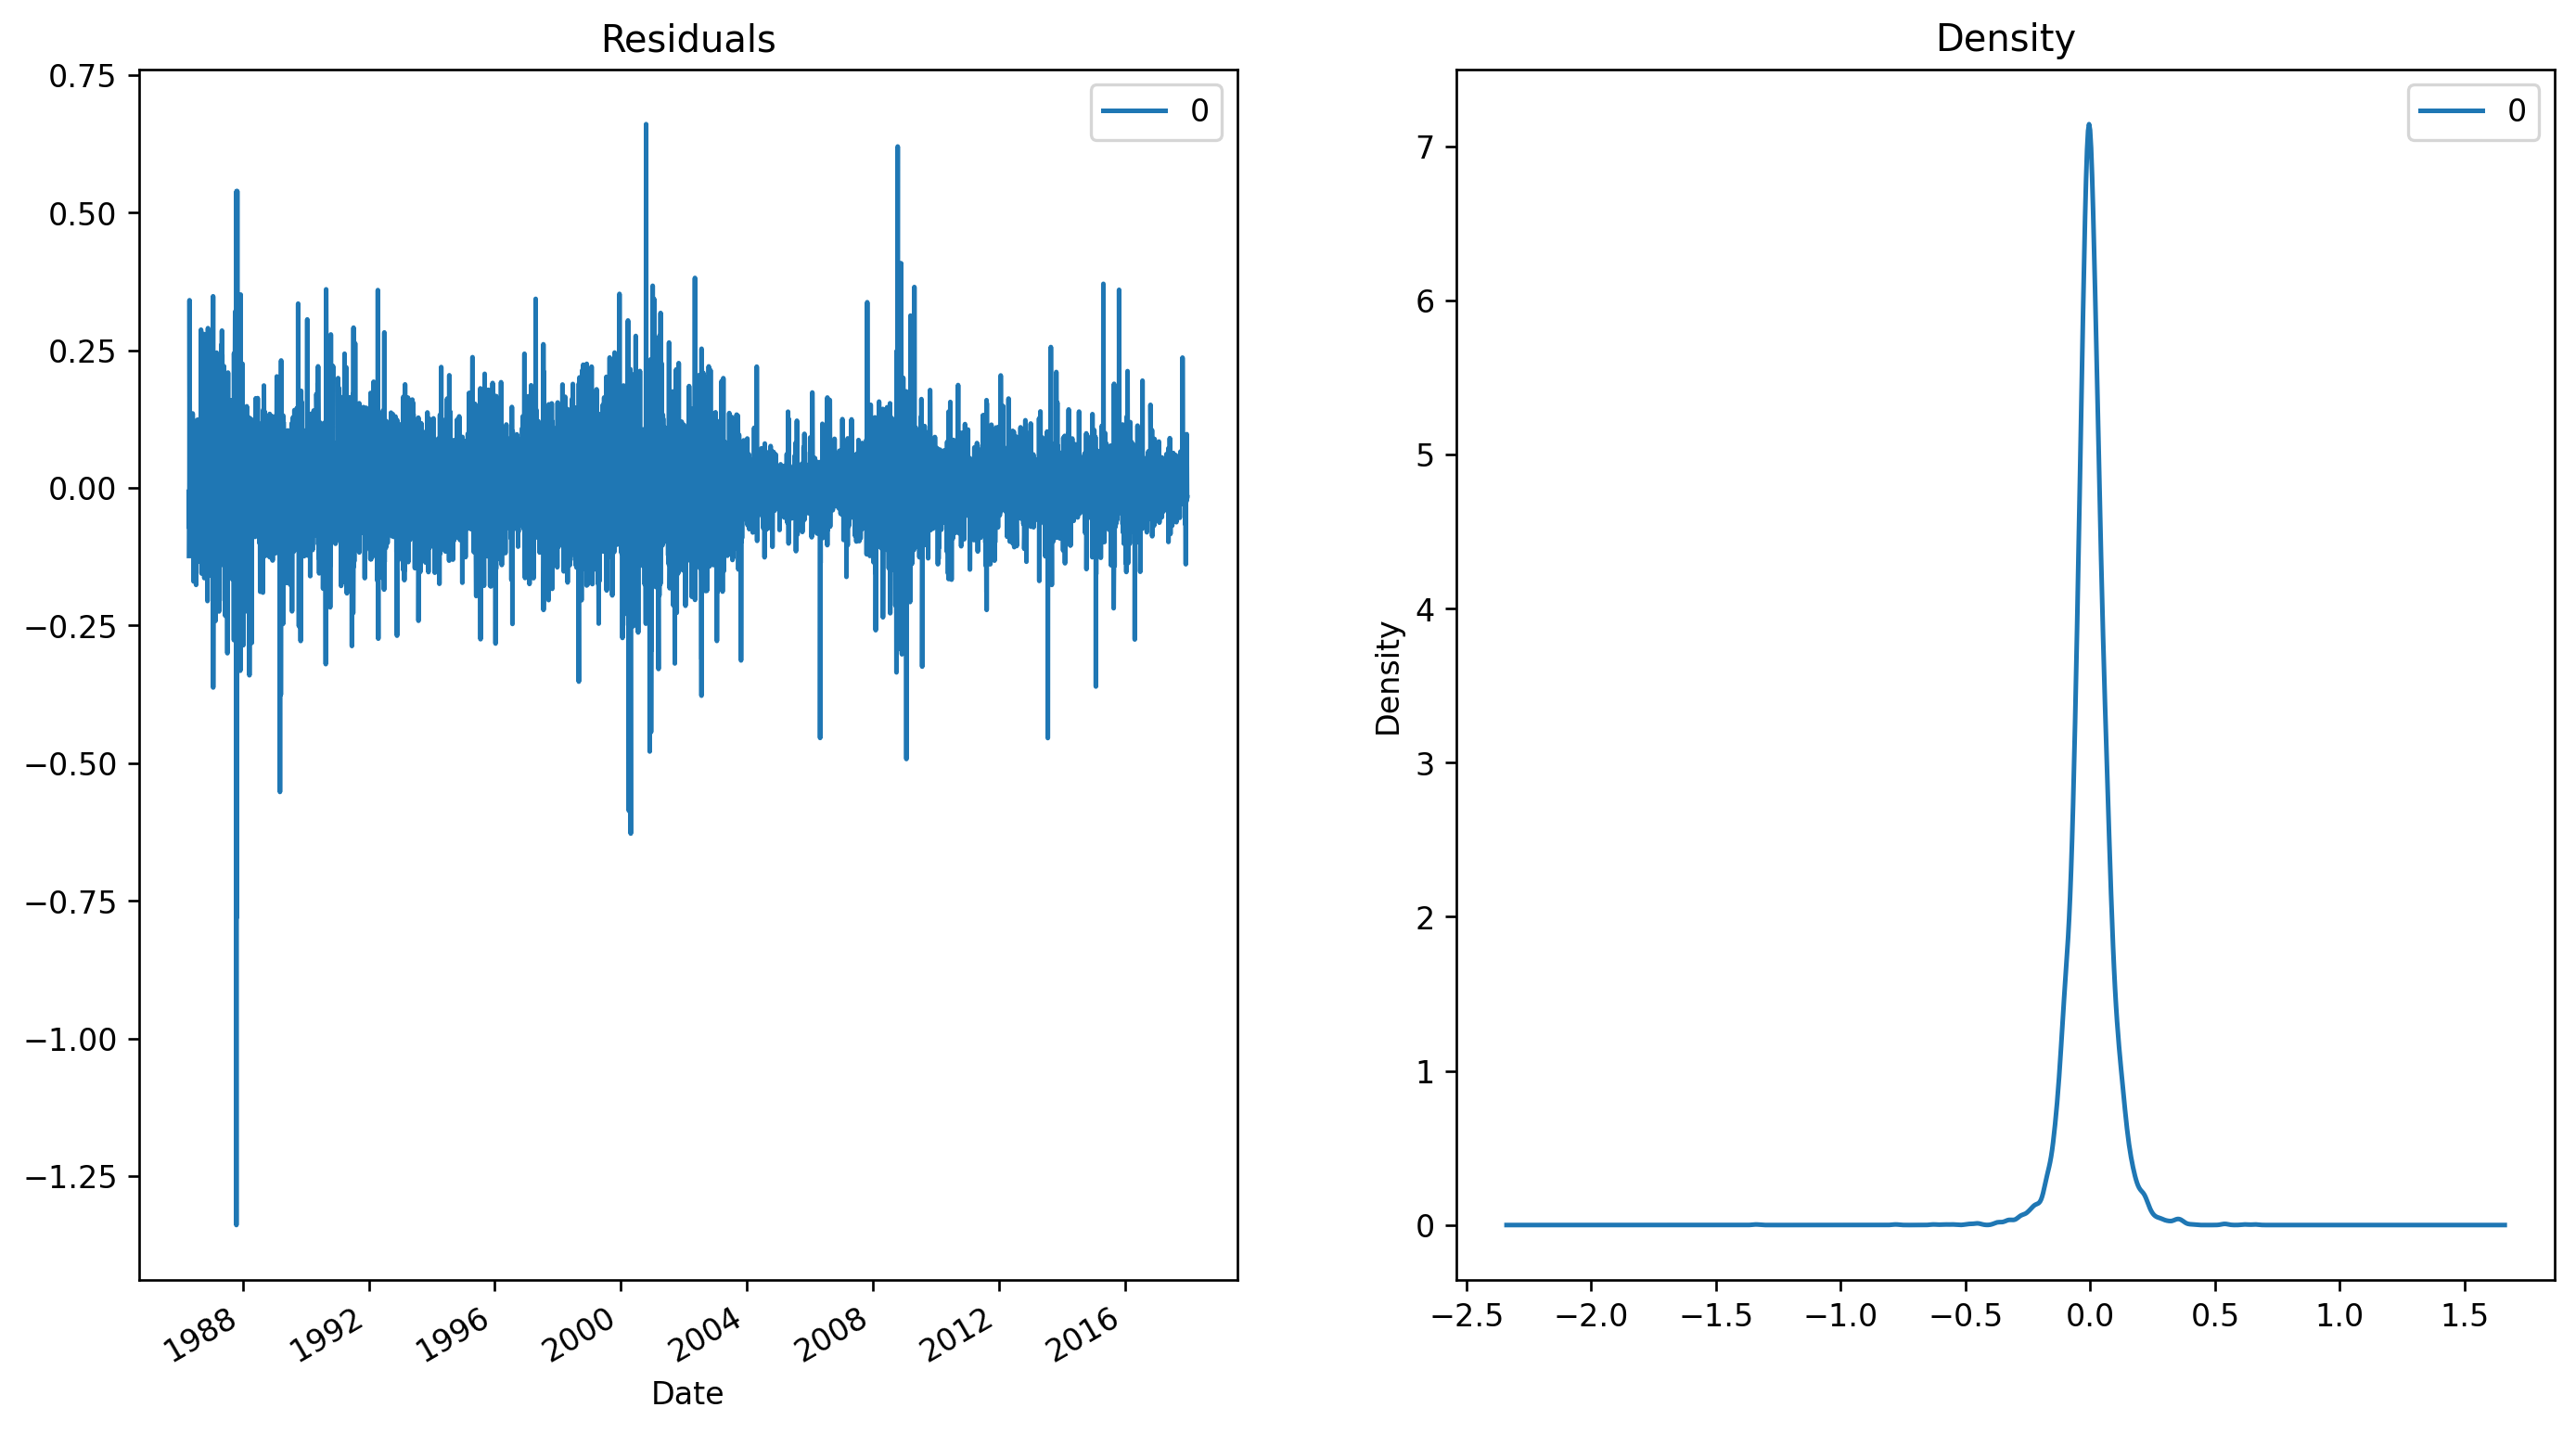

In [889]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(14,8))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
print ( "\n Constant  mean and variance has variannce observed")
plt.show()


In [890]:
## Residual Stationary 
test_stationarity(pd.DataFrame(model_fit.resid),0)

Results of Dickey-Fuller Test:

Time Series Stationary as P value ( 0.0 ) < 0.05


Test Statistic                  -53.368809
p-value                           0.000000
# Lags Used                       2.000000
Number of Observations Used    7984.000000
Critical Value (1%)              -3.431169
Critical Value (5%)              -2.861902
Critical Value (10%)             -2.566963
dtype: float64

<Figure size 600x360 with 0 Axes>

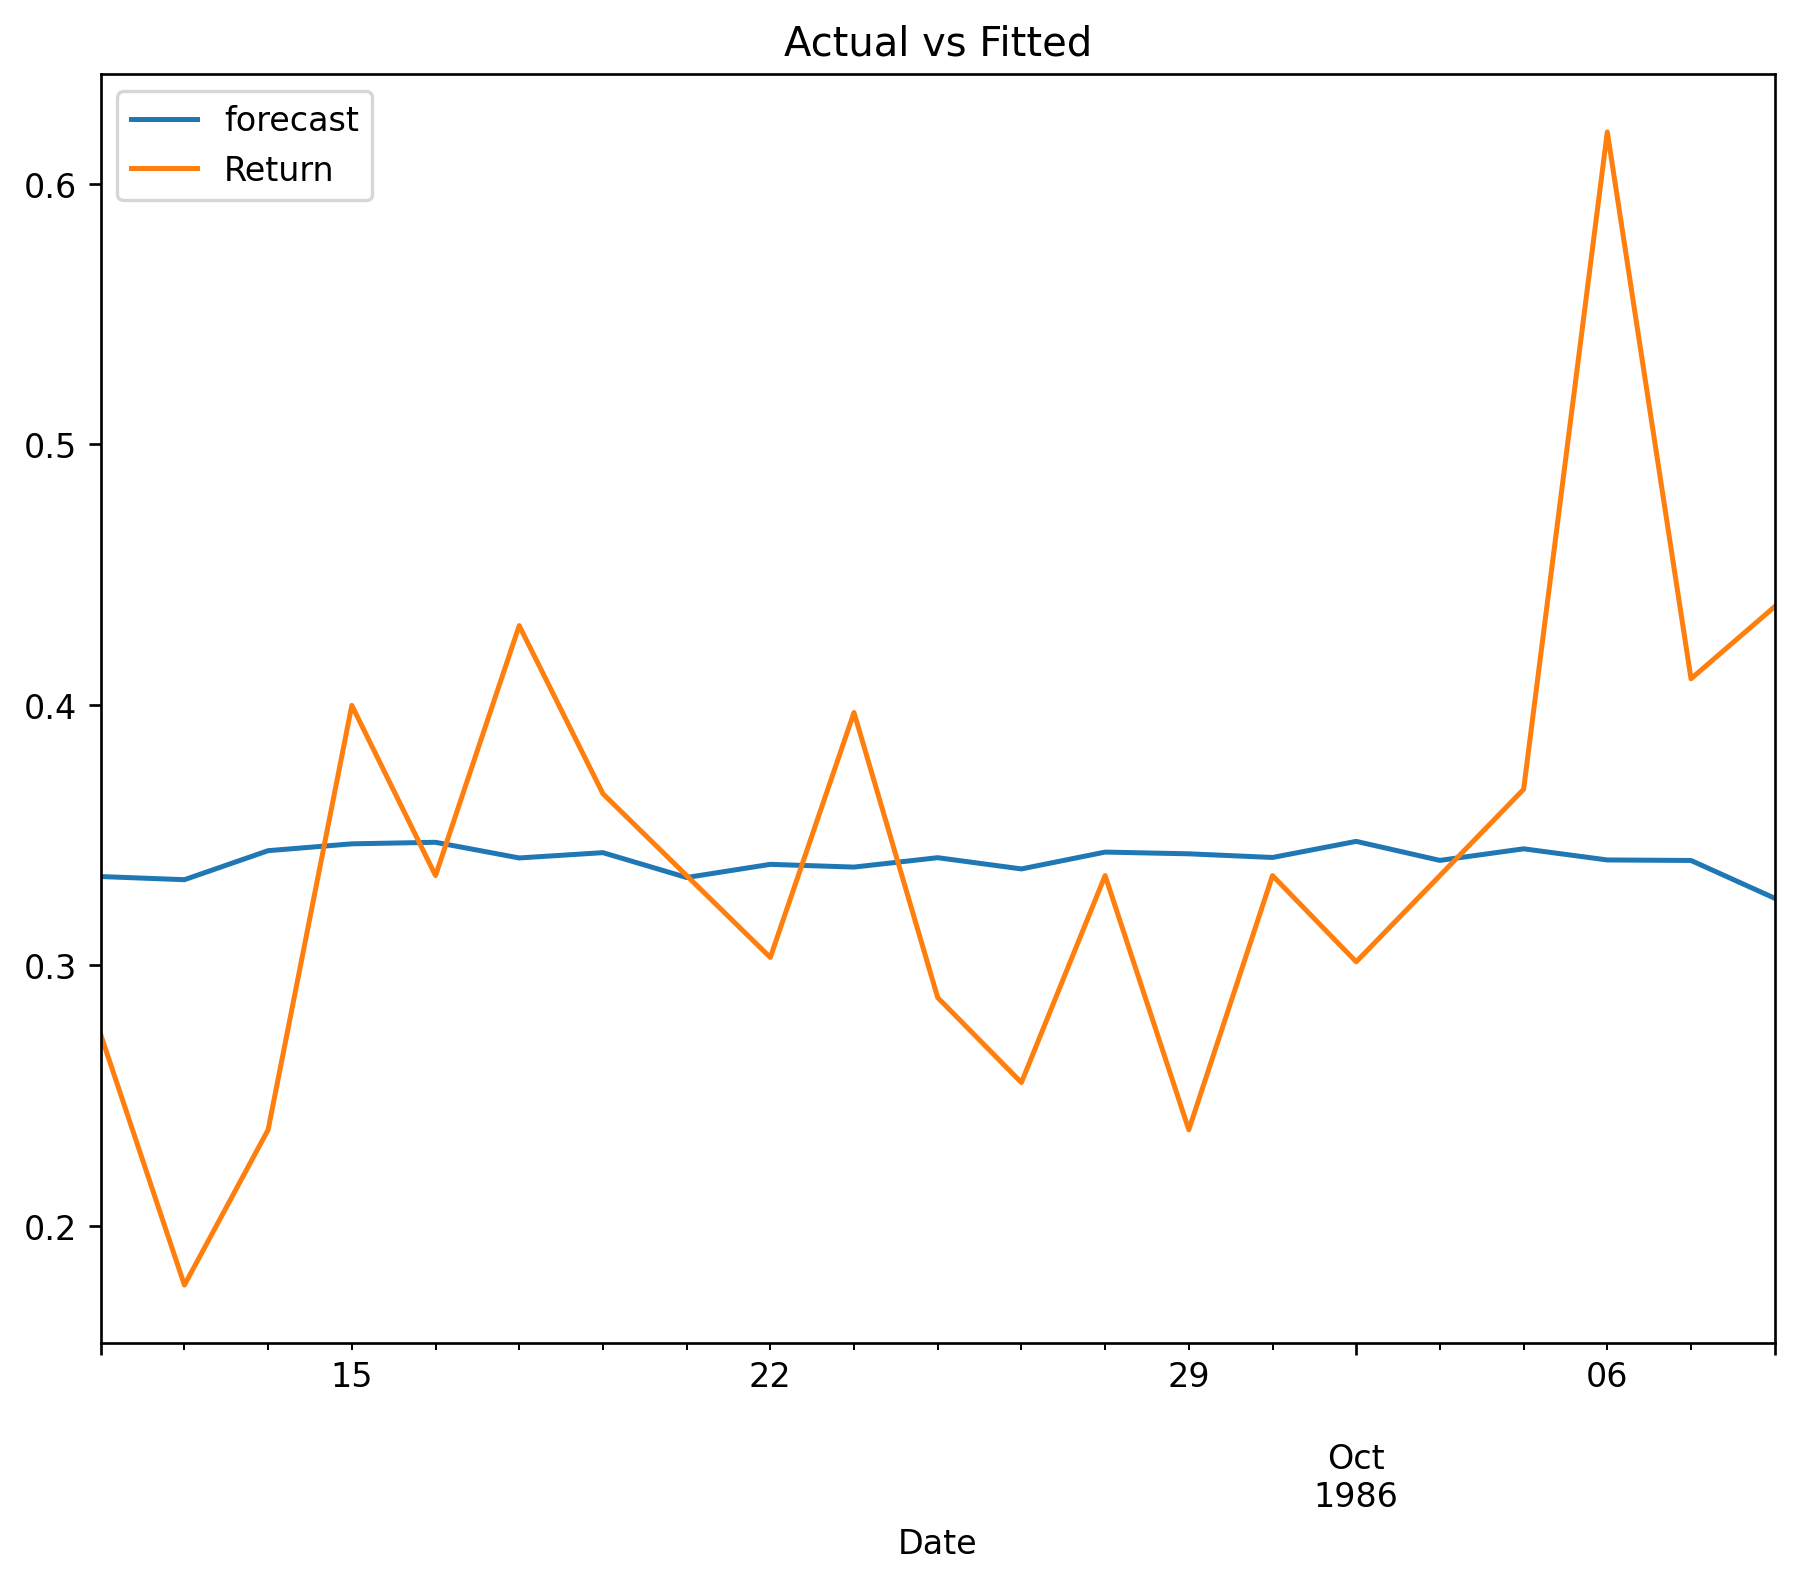

In [891]:
# Actual vs Fitted
plt.figure(figsize=(5,3))
#model_fit.plot_predict(dynamic=False, start=100, end=110)
model_fit.plot_predict(dynamic=False,  start=100, end=120)
plt.title("Actual vs Fitted")
plt.show()


### Forcasting using SARIMA 

In [898]:
col_list = []
col = ['ReturnLag_2','ReturnLag_4', 'ReturnLag_5','sma_21Lag_2','momentumLag_3','MACDLag_3']
for i in col:
    col_list.append(i)
    model = ARIMA(trainMinmax_y , order=(p, d, q))  
    model_fit = model.fit() 
    fc, se, conf = model_fit.forecast(valMinmax_y.shape[0], alpha=0.05)  
    mse = mean_squared_error(valMinmax_y, fc)
    print(f'\n MSE: {mse})


0.004286923661784253
0.004321100493477645
0.004335807026354639
0.004394851982510965
0.004319328500787199
0.004318930359288619


In [640]:
model = sm.tsa.statespace.SARIMAX(trainMinmax_y , order=(p, d, q),trend='c')
model_fit = model.fit() 
sarimaPred = model_fit.predict(start=1, end=100)

In [632]:
trainMinmax_y

Date
1994-02-04    0.016269
1994-02-07   -0.009282
1994-02-08   -0.026173
1994-02-09   -0.102573
1994-02-10    0.007907
                ...   
2018-09-26   -0.103285
2018-09-27    0.069173
2018-09-28    0.008613
2018-10-01   -0.005605
2018-10-02   -0.037200
Name: Return, Length: 6209, dtype: float64

In [602]:
results_arima = pd.DataFrame({'TestData_Y':valMinmax_y, 'Forecast_Y':fc})
results_arima.head(20)

,TestData_Y,Forecast_Y
Date,,
2018-10-03,-0.049804,0.032249
2018-10-04,-0.004548,-0.043329
2018-10-05,-0.028181,0.032414
2018-10-08,0.035754,-0.132659
2018-10-09,-0.049068,-0.056047
2018-10-10,-0.025176,-0.221017
2018-10-11,-0.146090,-0.011698
2018-10-12,-0.059875,-0.420517
2018-10-15,-0.092105,-0.100017


In [583]:
results_arima['test_direction'] = results_arima['TestData_Y'].diff() > 0
results_arima['fc_direction'] = results_arima['Forecast_Y'].diff() > 0
acc = (results_arima['test_direction'] == results_arima['fc_direction']).sum() / results_arima.shape[0]
acc

0.42028985507246375

In [584]:
mse = mean_squared_error(valMinmax_y, fc)
print(f'MSE: {mse}, EXOGS: {exogs}')

MSE: 0.024608446516157425, EXOGS: ['sma_21Lag_1', 'sma_21Lag_2', 'sma_21Lag_3', 'MACDLag_1', 'MACDLag_2', 'MACDLag_3', '20sdLag_1', '20sdLag_2', '20sdLag_3', 'momentumLag_1', 'momentumLag_2', 'momentumLag_3', 'lower_bandLag_1', 'lower_bandLag_2', 'lower_bandLag_3', 'upper_bandLag_1', 'upper_bandLag_2', 'upper_bandLag_3', 'ReturnLag_1', 'ReturnLag_2', 'ReturnLag_3', 'ReturnLag_4', 'ReturnLag_5']


In [562]:
import pmdarima as pm
model = pm.auto_arima(trainMinmax_y,
                      start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True, start_P=0, D=None, trace=True,error_action='ignore',  suppress_warnings=True, stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-9436.153, Time=3.43 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-9423.105, Time=0.41 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-9428.868, Time=0.51 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-9429.367, Time=0.53 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-9189.078, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-9430.686, Time=0.94 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-9431.277, Time=1.05 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-9433.368, Time=0.70 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-9432.598, Time=0.74 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-9432.927, Time=4.58 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-9185.144, Time=0.20 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 13.249 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:      

In [311]:
results_arima

,TestData_Y,Forecast_Y,test_direction,fc_direction
Date,,,,
2018-10-01,115.610001,115.360712,False,False
2018-10-02,115.150002,115.229675,False,False
2018-10-03,115.169998,115.229140,True,False
2018-10-04,112.790001,113.318396,False,False
2018-10-05,112.129997,112.345326,False,False
...,...,...,...,...
2019-07-24,140.720001,140.533097,True,True
2019-07-25,140.190002,140.459222,False,False
2019-07-26,141.339996,141.338783,True,True


In [900]:
ff = pd.read_csv(curl("https://raw.githubusercontent.com/sjv1030/Data607-Final/master/F-F_Research_Data_5_Factors_2x3_daily.CSV"),skip=3)

NameError: name 'curl' is not defined